In [1]:
import gdxpds
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
scenarios = list(['nodal', 'with_instrument', 'without_instrument']);
nodes = list(['north', 'south'])

In [3]:
scenarios = list(['nodal', 'with_instrument', 'without_instrument', 'agnostic_instrument']);

nodes = list(['north', 'south'])

In [4]:
def read_data(file, indicator):
    gams_dir='C:\Program Files\GAMS'
    df = gdxpds.to_dataframes(str(file) + '.gdx', gams_dir=gams_dir)
    df = df[indicator]
    df['model'] = file
    if 'Level' in df.columns:
        df['Value'] = df['Level']
    df['Value'] = df['Value'].round(2)
    return(df.set_index(['model']))

def read(indicator):
    if (len(scenarios) == 4):
        df = read_data(scenarios[0], indicator).append(read_data(scenarios[1], indicator)).append(read_data(scenarios[2], indicator)).append(read_data(scenarios[3], indicator))
    elif (len(scenarios) == 3):
        df = read_data(scenarios[0], indicator).append(read_data(scenarios[1], indicator)).append(read_data(scenarios[2], indicator))
    return(df)
    
def plot_distribution(df, axes, location):
    
    width = 0.8
    #baseload
    
    tmp = df.loc[df['tec'] == 'base'][location].fillna(0)
    tmp = tmp.reindex(index = scenarios)
    leg = axes.barh(y_pos, tmp, width, align='center', color = 'darkred')
    left = tmp.fillna(0)

    #peaker
    tmp = df.loc[df['tec'] == 'peak'][location].fillna(0)
    tmp = tmp.reindex(index = scenarios)
    axes.barh(y_pos, tmp, width, left=left, align='center', color = 'black')
    left = left + tmp.fillna(0)

    #wind
    tmp = df.loc[df['tec'] == 'wind'][location].fillna(0)
    tmp = tmp.reindex(index = scenarios)
    axes.barh(y_pos, tmp, width, left=left, align='center', color = 'lightblue')
    left = left + tmp.fillna(0)

    #solar
    tmp = df.loc[df['tec'] == 'solar'][location].fillna(0)
    tmp = tmp.reindex(index = scenarios)
    axes.barh(y_pos, tmp, width, left=left, align='center', color = 'gold')
    left = left + tmp.fillna(0)
    #leg.legend()
    return(axes)

    

In [5]:
df = read('o_gen')
df = df.reset_index().set_index(['model','t', 'n','tec'])
df = df.swaplevel().unstack()
df.columns = df.columns.droplevel(0)
df.columns.name = ''

df = df.groupby(['model','tec']).sum()
df = df.reset_index().set_index(['model'])
gen = df

In [6]:
gen

,tec,north,south
model,,,
agnostic_instrument,base,218.70,259.47
agnostic_instrument,peak,22.81,39.37
agnostic_instrument,solar,0.00,27.41
agnostic_instrument,wind,63.44,20.16
nodal,base,72.25,317.88
nodal,peak,69.73,19.27
nodal,solar,10.83,28.90
nodal,wind,94.33,35.97
with_instrument,base,69.93,320.25


In [7]:
gen['total'] = gen['north'] + gen['south']

In [8]:
gen['type'] = ['RE' if tec in ['wind', 'solar'] else 'non RE' for tec in gen['tec']]

In [9]:
re_shares = gen[['total', 'type']].groupby(['model', 'type']).sum()

In [10]:
re_shares = re_shares.unstack()

In [11]:
re_shares

total        
type                     RE  non RE
model                              
agnostic_instrument  111.01  540.35
nodal                170.03  479.13
with_instrument      170.03  481.32
without_instrument    69.56  581.20

In [12]:
re_shares['total', 'RE'] / (re_shares['total', 'RE'] + re_shares['total', 'non RE'])

model
agnostic_instrument    0.170428
nodal                  0.261923
with_instrument        0.261042
without_instrument     0.106890
dtype: float64

In [13]:
sums = gen.groupby(['model']).sum()
sums['total'] = sums[nodes[0]] + sums[nodes[1]]
sums = sums /48 * 8760
sums['share north'] = sums[nodes[0]] / sums['total']
sums
# in GWh

,north,south,total,share north
model,,,,
agnostic_instrument,55653.375,63219.825,118873.200,0.468174
nodal,45103.050,73368.650,118471.700,0.380707
with_instrument,44958.875,73912.500,118871.375,0.378214
without_instrument,59807.075,58956.625,118763.700,0.503580


# Installed capacities

In [14]:
df = read('o_cap')
df = df.reset_index().set_index(['model', 'n','tec'])
df = df.swaplevel().unstack()
df.columns = df.columns.droplevel(0)
df.columns.name = ''
df = df.reset_index().set_index(['model'])
capacities = df

In [15]:
capacities

,tec,north,south
model,,,
agnostic_instrument,base,18.88,22.19
agnostic_instrument,peak,5.18,8.48
agnostic_instrument,solar,0.00,18.26
agnostic_instrument,wind,25.78,9.78
nodal,base,6.17,27.47
nodal,peak,16.15,3.27
nodal,solar,7.85,19.26
nodal,wind,38.35,17.47
with_instrument,base,6.17,27.47


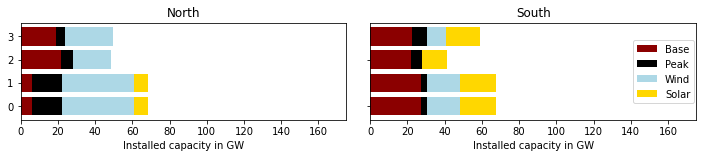

In [16]:
#plt.rcdefaults()
fig = plt.figure(figsize=(10, 2.3))

ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)

y_pos = np.arange(len(scenarios))
#leg = pd.Dataframe()

plot_distribution(capacities, ax1, 'north')
axes = plot_distribution(capacities, ax2, 'south')

ax1.set_xlim(0, 175)
ax2.set_xlim(0, 175)

ax1.set_title('North')
ax2.set_title('South')
                        
ax2.legend(['Base', 'Peak', 'Wind', 'Solar'], bbox_to_anchor=(1.01, 0.87))
ax1.set_yticks(y_pos);

if len(scenarios) == 3:
    ax1.set_yticklabels(['First-best', 'Second-best', 'Reference scenario'])
ax2.set_yticklabels([]);
ax1.set_xlabel('Installed capacity in GW')
ax2.set_xlabel('Installed capacity in GW')
plt.tight_layout()

fig.savefig('Figures/capacity_distribution.jpeg', dpi=500)

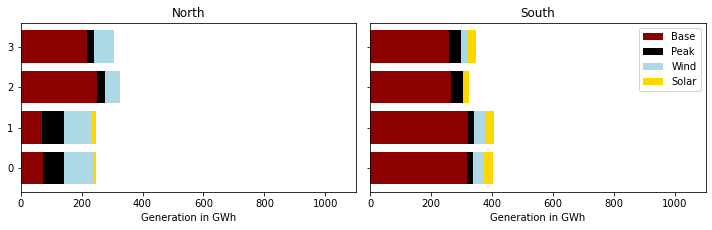

In [17]:
# plot generation
#plt.rcdefaults()
fig = plt.figure(figsize=(10, 3.3))

ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)

y_pos = np.arange(len(scenarios))
#leg = pd.Dataframe()

plot_distribution(gen, ax1, nodes[0])
axes = plot_distribution(gen, ax2, nodes[1])

ax1.set_xlim(0, 1100)
ax2.set_xlim(0, 1100)

ax1.set_title('North')
ax2.set_title('South')
                        
ax2.legend(['Base', 'Peak', 'Wind', 'Solar'], bbox_to_anchor=(1.0, 1))
#ax1.legend(['Base', 'Peak', 'Wind', 'Solar'])
ax1.set_yticks(y_pos);

if len(scenarios) == 3:
    ax1.set_yticklabels(['Nodal market', 'Locational instrument', 'Reference scenario']);
    
ax2.set_yticklabels([]);
ax1.set_xlabel('Generation in GWh')
ax2.set_xlabel('Generation in GWh')
plt.tight_layout()

fig.savefig('generation_distribution.jpeg', dpi=500)

# Welfare comparison

In [18]:
welfare = pd.DataFrame(index = scenarios, columns = ['Network cost', 'Generation cost', 'Gross consumer surplus'])

In [19]:
for scenario in scenarios:
    welfare.loc[scenario, 'Network cost'] = read_data(scenario, 'network_cost').iloc[0,0]
    welfare.loc[scenario, 'Generation cost'] = read_data(scenario, 'generation_costs').iloc[0,0]
    welfare.loc[scenario, 'Gross consumer surplus'] = read_data(scenario, 'consumer_surplus').iloc[0,0]

In [20]:
welfare['Welfare'] = welfare['Gross consumer surplus'] - welfare['Network cost'] - welfare['Generation cost'];
#welfare['Welfare'] = welfare['Welfare']



In [21]:
welfare = welfare / 1000

In [22]:
welfare.style.format('{0:,.2f}')

,Network cost,Generation cost,Gross consumer surplus,Welfare
nodal,2.47,49.21,401.08,349.41
with_instrument,2.59,49.36,401.36,349.41
without_instrument,3.94,49.71,401.29,347.64
agnostic_instrument,3.31,49.72,401.33,348.29


In [29]:
print('welfare gains through instrument in %')
    
print(round((welfare['Welfare']['with_instrument'] - welfare['Welfare']['without_instrument']) / welfare['Welfare']['without_instrument'] * 100,6))

print('welfare gains through nodal pricing in %')
    
print(round((welfare['Welfare']['nodal'] - welfare['Welfare']['without_instrument']) / welfare['Welfare']['without_instrument'] * 100,6))

if len(scenarios) > 3:
    print('welfare gain through uniform signal in %')
    print(round((welfare['Welfare']['agnostic_instrument'] - welfare['Welfare']['without_instrument']) / welfare['Welfare']['with_instrument'] * 100,2))


welfare gains through instrument in %
0.5073
welfare gains through nodal pricing in %
0.507303
welfare gain through uniform signal in %
0.19


# Instrument level

In [30]:
fixed_costs = read_data('with_instrument', 'c_fix').reset_index(drop = True).set_index(['tec','n']).unstack()
fixed_costs.columns = fixed_costs.columns.droplevel(0)

In [31]:
fixed_costs

n,north,south
tec,,
base,411.0,411.0
peak,151.0,151.0
solar,82.0,82.0
wind,137.0,137.0


In [32]:
instr = read_data('with_instrument', 'o_instrument').reset_index(drop = True).set_index(['tec','n']).unstack()
instr.columns = instr.columns.droplevel(0)
instr = instr.round(1)

In [33]:
instr

n,north,south
tec,,
base,12.4,5.3
peak,-16.0,-11.7
solar,2.3,7.5
wind,5.1,-2.2


In [187]:
cap = read_data('with_instrument', 'o_cap').reset_index(drop = True).set_index(['tec','n']).unstack()
cap.columns = cap.columns.droplevel(0)
instr[cap.isna()] = np.nan

In [188]:
shares = round(100 *instr / fixed_costs,1)

In [189]:
shares = shares.rename(columns={'north':'north (share)', 'south': 'south (share)'})
#shares.columns = shares.columns.droplevel(0)

In [190]:
shares

n,north (share),south (share)
tec,,
base,-0.8,-2.0
peak,-22.6,-21.3
solar,6.6,6.1
wind,3.0,-2.0


In [191]:
instrument = pd.concat([instr, shares], axis=1)
instrument = instrument.sort_index(axis = 1)

In [192]:
#fixed_costs.columns = fixed_costs.columns.droplevel(0)
instrument['Fixed cost'] = fixed_costs['north']

In [193]:
format_dict = {'north':'{0:,.0f} €', 'north (share)': '{0:,.0f}%', 'south': '{0:,.0f} €', 'south (share)': '{0:,.0f}%', 'Fixed cost': '{0:,.0f} €'}
instrument.style.format(format_dict)

n,north,north (share),south,south (share),Fixed cost
tec,,,,,
base,-3 €,-1%,-8 €,-2%,411 €
peak,-34 €,-23%,-32 €,-21%,151 €
solar,5 €,7%,5 €,6%,82 €
wind,4 €,3%,-3 €,-2%,137 €


In [194]:
instr

n,north,south
tec,,
base,-3.2,-8.2
peak,-34.1,-32.2
solar,5.4,5.0
wind,4.1,-2.7
